In [2]:
import math

from PIL import Image, ImageColor
import IPython.display

from Position import Position
from Piece import Piece
from Board import Board
from Game import Game


# See Game.py to check, how an implementation of a bot should look like so that it can play games in Engine

# A simple bot, which chooses the first white piece and moves it one field forward-right,
# without checking if it's a correct move.
# It usually looses after a few moves when it attempts to make an incorrect move
class SampleBot:
    def make_move(self, board):
        piece = board.whites[0]
        return [piece.position(), piece.position().add(1, 1)]


class SampleBotOne:
    def make_move(self, board):
        if len(board.whites) > 0:
            piece = board.whites[1]
        else:
            piece = board.whites[0]
        return [piece.position(), piece.position().add(1, 1)]

class MinMaxBot:
    def __init__(self, max_depth):
        self.max_depth = max_depth
    def heuristic_state_value(self, board):
        return len(board.whites) / (len(board.whites) + len(board.blacks))
    def min_max(self, board, depth):
        if depth == self.max_depth:
            return 1 - self.heuristic_state_value(board)
        value = 0
        res_move = []
        for move in board.possible_moves():
            child_value = 1 - self.min_max(board.make_move(move), depth + 1)
            if child_value >= value:
                value = child_value
                res_move = move
        if depth == 0:
            return res_move
        return value
    def make_move(self, state):
        return self.min_max(state, 0)
# moves = board.possible_moves()
# for move in moves:
#     print(move)
#     board.revert().show()
#     board.make_move(move).show()

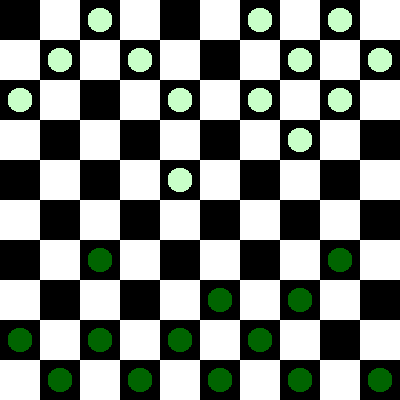

KeyboardInterrupt: Interrupted by user

In [3]:
# Suppose you have a class SampleBot and want to play againt it. Run:
bot = MinMaxBot(2)
game = Game(bot, None)
game.play_human(False, True)

# When you are asked to specify your move in a textfield, specify it similarly as in a bot.
# However, don't wrap the locations into Positions class or a list - just list the numbers.
# For instance, to move from position (2, 0) to position (3, 1) just type: 2 0 3 1
# Also, remember that we firstly specify the row number and then the column number
# and that the upper-left field is (0, 0)

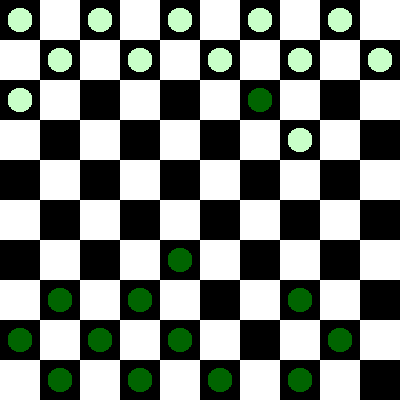

In [ ]:
# Suppose you have classes SampleBot, SampleBotOne and want them to play against each other. Run:
bot = MinMaxBot(4)
botOne = MinMaxBot(4)
game = Game(bot, botOne)
game.play_bots()